In [1]:
import pandas as pd
import numpy as np
# 统计notavailable的情况
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False  
import seaborn as sns
from 处理文件 import Process_data 

#模型搜索、调优、比较、展示包
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from hyperopt import tpe,fmin,Trials,hp,rand,anneal,space_eval
file_path="E:/python/数据分析语言基础/大作业/脚本和notebook/"

In [2]:
res=Process_data(file_path+"Beijing-result-2021-10-26.csv")
X_columns=res["X_columns"]
X_train,X_test,y_train,y_test=res["X_train"],res["X_test"],res["y_train"],res["y_test"]



正在处理: E:/python/数据分析语言基础/大作业/脚本和notebook/Beijing-result-2021-10-26.csv
 正在删除强相关变量...
  删除前: (19675, 123)
 删除完成 (19675, 118)
请核对训练集，测试集形状:
X_train.shape: (14756, 116)
y_train.shape: (14756,)
X_test.shape: (4919, 116)
y_test.shape: (4919,)


In [3]:
class Machine(object):
    """定义一个Machine的类。
    本Machine类的思路如下：
    任何一个特殊的模型如SVC都可以用来建立Machine类
    通过调用self.headquater方法可以完成从hyperopt参数寻优一直到模型报告的过程
    如果想象征性的跑一跑代码看看能不能跑通，把HyperoptTrain(self,max_evals=50)中的50改为较小的数字即可（比如3）"""
    def __init__(self,clf,params:dict,
                 X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
        self.X_train=X_train
        self.y_train=y_train
        self.X_test=X_test
        self.y_test=y_test
        self.clf=clf
        self.params=params
    def Report(self):
        """报告分类性能的函数,同时画出分类结果ROC函数"""
        y_train_predict=self.clf.predict(self.X_train)
        y_predict=self.clf.predict(self.X_test)
        train_mae=mean_absolute_error(y_true=self.y_train,y_pred=y_train_predict)
        train_mse=mean_squared_error(y_true=self.y_train,y_pred=y_train_predict)
        train_r2=r2_score(y_true=self.y_train,y_pred=y_train_predict)
        test_mae=mean_absolute_error(y_true=self.y_test,y_pred=y_predict)
        test_mse=mean_squared_error(y_true=self.y_test,y_pred=y_predict)
        test_r2=r2_score(y_true=self.y_test,y_pred=y_predict)
        
        print("="*60)    
        print("train数据集上模型精度指标(MAE,MSE,R2):",[train_mae,train_mse,train_r2])
        print("test数据集上模型精度指标(MAE,MSE,R2):",[test_mae,test_mse,test_r2])
        print("="*60)    
    def objective(self,params):
        self.clf.set_params(**params)
        res=np.nanmean(cross_val_score(self.clf,self.X_train,self.y_train,scoring="r2",
                                   cv=5))
        return -res
    def HyperoptTrain(self,max_evals=50):
        """使用tpe.suggest寻找最优参数"""
        trials=Trials()
        if self.model_name!="SVR":
            self.params["random_state"]=hp.choice("random_state",[0]) #加一个random_state操作
        best_params=fmin(fn=self.objective,space=self.params,
                         algo=tpe.suggest,max_evals=max_evals,trials=trials)
        best_params=space_eval(self.params, best_params)
        np.save(file_path+self.model_name+"best_params",best_params)
        print("best params:\n",best_params)
        self.clf.set_params(**best_params)
        self.clf.fit(self.X_train,self.y_train)
        return self.clf
    def headquarter(self,model_name):
        """中心调度器，完成从模型训练直到模型报告的所有工作"""
        self.model_name=model_name
        self.clf=self.HyperoptTrain()
        print(model_name,"模型","训练完成，下面是模型报告：")
        self.Report()
        return self.clf


In [1]:
from lightgbm import LGBMRegressor
clf_LGBM=LGBMRegressor()

In [2]:
import lightgbm as lgb


In [ ]:
lgb.LGBMRegressor().fit(callbacks=)
lgb.train()

In [4]:
from lightgbm import LGBMRegressor
clf_LGBM=LGBMRegressor()
params_LGBM={
        "boosting_type":hp.choice("boosting_type",['gbdt']),
        'max_depth': hp.randint('max_depth', 12),
        'num_leaves':  hp.choice('num_leaves', np.arange(30, 150,10, dtype=int)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice("n_estimators",np.arange(100, 200, 20,dtype=int))
    }
LGBM_machine=Machine(clf_LGBM,params_LGBM)
clf_LGBM=LGBM_machine.headquarter(model_name="LGBM")


100%|██████████| 50/50 [02:42<00:00,  3.26s/trial, best loss: -0.43157555822989346]
best params:
 {'boosting_type': 'gbdt', 'learning_rate': 0.042042151566098876, 'max_depth': 0, 'n_estimators': 160, 'num_leaves': 110, 'random_state': 0}
LGBM 模型 训练完成，下面是模型报告：
train数据集上模型精度指标(MAE,MSE,R2): [0.17528454416567063, 0.06016110239305189, 0.6352357008753893]
test数据集上模型精度指标(MAE,MSE,R2): [0.2152004478719984, 0.09001394192860733, 0.45193358795805094]


In [5]:
feature_importance=clf_LGBM.feature_importances_
sort_index=np.argsort(feature_importance)
print("重要性:",feature_importance[sort_index[:-6:-1]])
print("特征名称：",X_columns[sort_index[:-6:-1]].to_numpy())


重要性: [3874 1599 1536 1496  992]
特征名称： ['adjusted_price' 'host_time' 'latitude' 'longitude' 'sentiment']


TypeError: list indices must be integers or slices, not list

In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
clf_SVR=SVR()
params_SVR={
        "C":hp.uniform("C",0.1,1),
        'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(0.1))    
           }
SVR_machine=Machine(clf_SVR,params_SVR)
clf_SVR=SVR_machine.headquarter(model_name="SVR")


100%|██████████| 50/50 [1:55:59<00:00, 139.18s/trial, best loss: -0.34956158733403686]
best params:
 {'C': 0.33881872628191173, 'gamma': 0.0871372329588398}
SVR 模型 训练完成，下面是模型报告：
train数据集上模型精度指标(MAE,MSE,R2): [0.1931098828252599, 0.08146831209575954, 0.5060474196711726]
test数据集上模型精度指标(MAE,MSE,R2): [0.22312324289099478, 0.10266376243586743, 0.37491283328554226]


In [7]:
from sklearn.linear_model import ElasticNet
clf_Ela=ElasticNet()
param_Ela={
        "alpha":hp.uniform("alpha",0.1,0.9),
        # "penalty":hp.choice("penalty",['elasticnet']),
        "l1_ratio":hp.uniform("l1_ration",0.1,0.9)
        # 'solver': hp.choice("solver",['saga'])    
}
Ela_machine=Machine(clf_Ela,param_Ela)
Ela_machine.headquarter(model_name="ElasticNet")


100%|██████████| 50/50 [00:32<00:00,  1.55trial/s, best loss: -0.0459686820962202]  
best params:
 {'alpha': 0.12008557708622626, 'l1_ratio': 0.140416862133309, 'random_state': 0}
ElasticNet 模型 训练完成，下面是模型报告：
train数据集上模型精度指标(MAE,MSE,R2): [0.34977030028413136, 0.15684075854546556, 0.04905483627546836]
test数据集上模型精度指标(MAE,MSE,R2): [0.3492762689950713, 0.15656951302788566, 0.046697773680356214]


ElasticNet(alpha=0.12008557708622626, l1_ratio=0.140416862133309,
           random_state=0)

 # 三种算法总结
 * SVR 能凑合，但是算的太慢，7分钟才算完一个
 * Ela一开始属性太差，还需要再调参
 * light GBM效果属实很惊艳

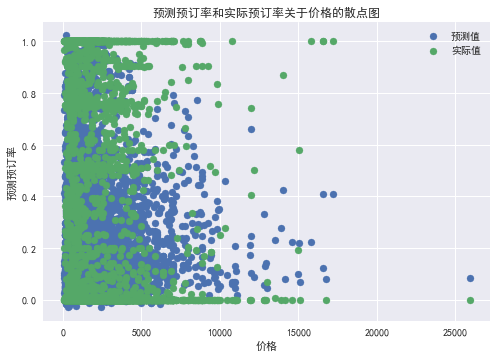

In [8]:
y_pre=clf_LGBM.predict(X_test)
price=np.exp(X_test[:,0]*res["scale"][0]+res["mean"][0])
fig=plt.figure()
plt.scatter(price,y_pre,label="预测值")
plt.scatter(price,y_test,label="实际值")
plt.title("预测预订率和实际预订率关于价格的散点图")
plt.xlabel("价格")
plt.ylabel("预测预订率")
plt.legend();
plt.show();


